In [1]:
## 필요한 모듈 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드시 더 빠르게 로드할 수 있도록 해주는 설정변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트 진행시 변경할 파라미터
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


`tf.io.gfile.glob`은 주어진 패턴과 일치하는 파일 목록을 반환한다.


각 데이터 수는 train = 5216, test = 624, val = 16개로   
비율은 89:10.7:0.3으로 val가 너무 적다.   

따라서 아래 코드는 train데이터와 validation 데이터를 합쳐서 다시 train, validation 데이터로 나눠준다

In [4]:
# train 데이터 validation 데이터 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')      

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


훈련 데이터를 정상과 폐렴을 구분해야하는데  
이를 파일 이름을 가지고 구분한다   

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


위 결과를 보면 정상보다 폐럼 이미지가 3배 정도 많이 있다.  
앞으로 사용할 CNN 모델은 데이터가 클래스별 balance가 좋을 수록 훈련을 잘 한다.   
조금있다가 조정해줄 예정

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

`tf.data.Dataset.from_tensor_slices()`를 사용해 `tf.Tensor`로 변환한다

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


`tf.data.experimental.cardinality`는 cardinality를 반환한다.   
결과값을 통해 중복되는 값이 없다고 볼 수 있다.

#### cardinality란?

>카디널리티는 특정 데이터 집합의 유티크한 값의 개수를 나타낸다
예를 들어 데이터에 성별 컬럼이 있을때 카디널리티는 2이다.
반대로 주민등록번호는 모든 데이터가 유니크할 것이므로 주민등록번호의 카디널리티는 데이터 개수와 동일할 것이다

카디널리티는 전체 행에 대한 특정 컬럼의 중복 수치를 나타내는 지표로  
중복도가 낮으면 카디널리티가 높다고 표현하고   
중복도가 높으면 카디널리티가 낮다고 표현한다.   

카디널리티는 상대적인 개념으로   
예를 들어 주민등록번호는 중복이 없기 때문에 카디널리티가 높다고 표현할 수 있고,   
이름은 중복되는 경우가 많기 때문에 `주민등록번호에 비해` 카디널리티가 낮다고 표현할 수 있다.   
`주민등록번호에 비해 이름이` 이런 식으로 상대적인 개념으로 이해한다.



In [9]:
# 라벨 데이터가 없기 때문에 label을 만들어주는 함수

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  

`tf.strings.split`는 input을 sep 기준으로 RaggedTensor로 분할한다.  
매개변수는 순서대로 (input, sep=None, maxsplit=-1, name=None)   

> 예시  
`>>>`tf.strings.split('hello world').numpy()    
array([b'hello', b'word'], dtype=object)   
`>>>`tf.strings.split(['hello world', 'a b c'])   
<tf.RaggedTensor [[b'hello', b'world'], [b'a', b'b', b'c']]>    

예시랑 아무리 찾아봐도 이게 어떻게 동작하는지 잘 모르겠다


In [10]:
## 이미지 사이즈 통일 시키고 GPU 메모리를 효율적으로 사용하기 위해 이미지 사이즈 줄인다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈 IMAGE_SIZE로 수정
    return img
    
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label
    

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape : ", image.numpy().shape)
    print("Label : ", label.numpy())

Image shape :  (180, 180, 3)
Label :  False


In [13]:
## 똑같이 test 데이터 셋 만들기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGES_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGES_COUNT)

624


앞의 실습과 다르게 `augment` 함수를 추가해 좌우반전을 추가해본다

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.shuffle(buffer_size = shuffle_buffer_size)  # 고정크기 버퍼 유지, 셔플
#     ds = ds.repeat()  # epoch 진행하면서 불러온 데이터셋을 여러번 사용할 수 있게 해줌
#     ds = ds.batch(BATCH_SIZE)  # batch_size
#     ds = ds.prefetch(buffer_size=AUTOTUNE)  # 학습데이터를 나눠서 읽어와 앞에 데이터를 학습하는 동안 다음 데이터를 준비한다.
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

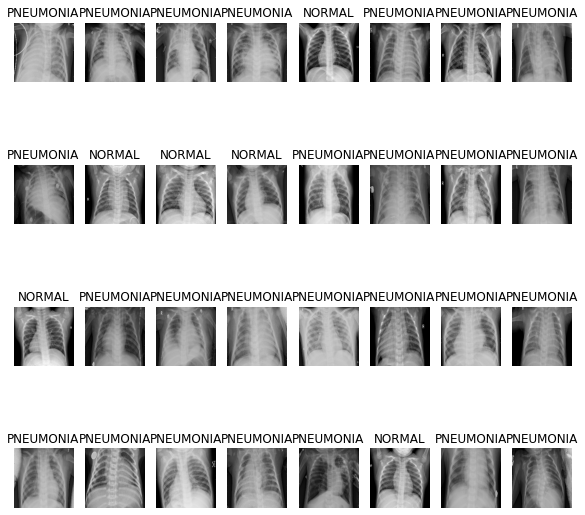

In [16]:
## 데이터 시각화 
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


# CNN 모델링하기

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block
    

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3)
    ])
    
    return block

`BatchNormalization()` 배치 정규화와 `Dropout` 두 가지 regularization 기법을 동시에 사용


In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [20]:
## imbalance 처리하기

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for NORMAL : {:.2f}".format(weight_for_0))
print("Weight for PNEUMONIA : {:.2f}".format(weight_for_1))

Weight for NORMAL : 1.95
Weight for PNEUMONIA : 0.67


imbalance를 처리하기위해 가중치를 다르게 주는 방법을 사용했다.

## 모델 훈련하기

In [21]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        
    )

Epoch 1/25
130/130 [==============================] - 61s 367ms/step - loss: 0.3563 - accuracy: 0.8325 - precision: 0.9601 - recall: 0.8083 - val_loss: 0.6347 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 48s 373ms/step - loss: 0.2132 - accuracy: 0.9224 - precision: 0.9737 - recall: 0.9206 - val_loss: 0.8127 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 50s 384ms/step - loss: 0.1835 - accuracy: 0.9334 - precision: 0.9782 - recall: 0.9310 - val_loss: 1.1027 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 51s 391ms/step - loss: 0.1523 - accuracy: 0.9486 - precision: 0.9806 - recall: 0.9496 - val_loss: 1.4328 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 54s 415ms/step - loss: 0.1358 - accura

25번으로 계속 돌리는데 계속 12번, 13번째에서 끊긴다   
열받는다...  



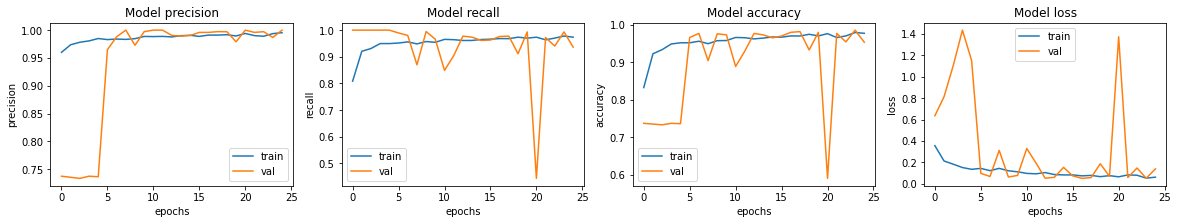

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 230ms/step - loss: 0.4086 - accuracy: 0.8526 - precision: 0.8326 - recall: 0.9564
Loss: 0.4085546135902405,
Accuracy: 0.8525640964508057,
Precision: 0.8325892686843872,
Recall: 0.9564102292060852



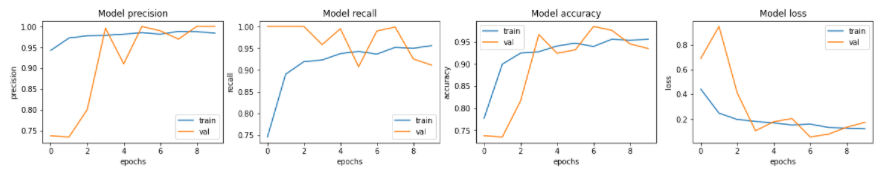

처음 batch_size = 16, epochs = 10으로 주고 돌린 결과   

지금 폐렴 분류에서 중요한 것은 정상을 폐렴으로 오인하는 것은 그나마 괜찮지만   
폐렴을 정상으로 오인하는 것은 큰 실수이기 때문에 Recall 값에 좀더 중점을 두고 Recall 값이 괜찮은 epoch를 준다.   
또한 Recall 값이 제일 괜찮게 나오는 모델이 가장 적절할 것으로 사료된다.

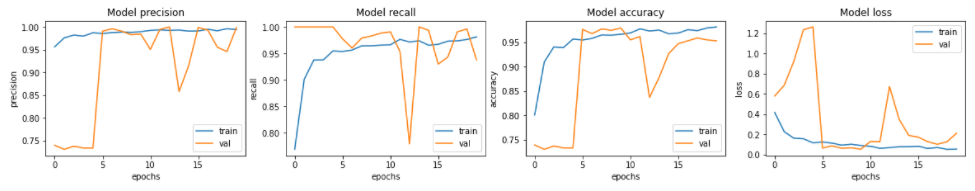
batch_size = 32, epochs = 20으로 돌린 결과
epochs가 10번이 넘어가면 무의미한 훈련으로 보인다
다시 10번으로 줄이자

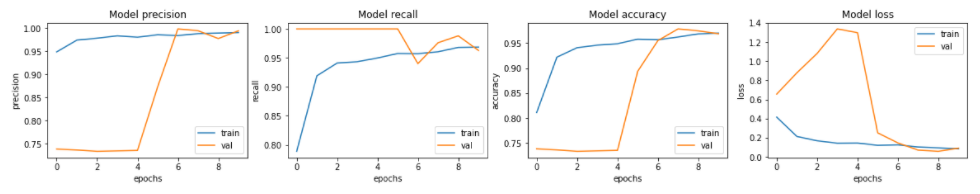
batch_size = 32, epochs = 10으로 돌린 결과
그래프 모양도 나쁘지 않고 다 괜찮은데 accuracy 값이 81%로 감소했다

중간에 batch_size랑 epoch를 바꿔주면서 든 생각인데 batch_size가 영향을 주는 가에 대해서 의문이 들었다.   
batch_size를 통해 훈련하는 데이터 수를 제한하면서 학습효과를 더 좋게 하는 것이 취지인데, 이 데이터는 데이터 수가 적어서 그런지 별 차이가 크게 안나는 것처럼 느껴졌다.

### augmentation 사용 했을 때

노드에는 augmentation을 사용해보라고 해서 해봤는데 이상하게 계속 70% 대의 성능을 보인다.
batch_size를 16, 32 epoch를 10, 20 각각 섞어서 실행을 해봐도 계속 성능이 70%대를 출력해서 augmentation을 사용하지 않기로 했다.

했을때 캡쳐해서 남겨놨어야 되는데, 결과가 너무 충격이라서 계속 이것저것 시도해본다고 결과값이 남은게 없다....

#### 다시 변경 - augmentation 사용

혹시나 하는 마음에 마지막으로 batch_size 32, epoch 25를 주고 돌려보니 겨우 85%가 넘은 것을 확인했다   
중요하게 생각하는 **Recall**값도 높게 나오는 것을 확인했다.

